In [4]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np

%matplotlib notebook

# Set optional variables for plot style to default None (if applicable specify values WITH file_name declaration)
GPS_time = None
clims = None

##################################################################################################
##### 2021 Tests
#################################################################################
path = "./ExpIntegration_Feb16/"
#file_name = "data_file_230k_usbserial-A105BN3L.txt"
#file_name = "Shield17_Dallas1-data_file_230k_usbserial-FT1HC8A7.txt"
#file_name = "ExpIntegration_Dallas1-Bob17_2-16-2021.txt"
#file_name = "Shield17_Dallas4-data_file_230k_usbserial-FT1HC8A7.txt"
#file_name = "ExpIntegration_Dallas4-Bob17_2-16-2021.txt"

#file_name = "NoKdata_Shield16_Dallas4-data_file_230k_usbserial-FT1HC8A7.txt"
#file_name = "ExpIntegration_Dallas4-Bob16_2-16-2021.txt"
#file_name = "Shield16_Dallas4-data_file_230k_usbserial-FT1HC8A7.txt"
#file_name = "ExpIntegration_Dallas1-Bob14_2-16-2021.txt"
#file_name = "data_file_230k_usbserial-A105BN3L.txt"

path = "./Fw_Swarm_DART_data_recordings/"
file_name ="d1r4_gnd_decom_gse_lap"

##################################################################################################

dataFile = path + file_name

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
        self.timeRpt = []; self.tempRpt = []
        self.axRpt = []; self.ayRpt = []; self.azRpt = []
        self.mxRpt = []; self.myRpt = []; self.mzRpt = []
        self.gxRpt = []; self.gyRpt = []; self.gzRpt = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
        self.timeRpt = []
        self.pip0Rpt = []; self.pip1Rpt = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    
    dataSet.imu.axRpt = dataSet.imu.axRpt.tolist()
    dataSet.imu.ayRpt = dataSet.imu.ayRpt.tolist()
    dataSet.imu.azRpt = dataSet.imu.azRpt.tolist()
    dataSet.imu.mxRpt = dataSet.imu.mxRpt.tolist()
    dataSet.imu.myRpt = dataSet.imu.myRpt.tolist()
    dataSet.imu.mzRpt = dataSet.imu.mzRpt.tolist()
    dataSet.imu.gxRpt = dataSet.imu.gxRpt.tolist()
    dataSet.imu.gyRpt = dataSet.imu.gyRpt.tolist()
    dataSet.imu.gzRpt = dataSet.imu.gzRpt.tolist()
    dataSet.imu.tempRpt = dataSet.imu.tempRpt.tolist()
    dataSet.imu.timeRpt = dataSet.imu.timeRpt.tolist()
    dataSet.sweeps.timeRpt = dataSet.sweeps.timeRpt.tolist()
    dataSet.sweeps.pip0Rpt = dataSet.sweeps.pip0Rpt.tolist()
    dataSet.sweeps.pip1Rpt = dataSet.sweeps.pip1Rpt.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()
    
# Functions for padding data

# padding time data as lists
def timefix(l, new, dt):   # l = time data as list, new = empty list, dt = delta t
    for t in l:
        if l.index(t) >= 2:
            # replace bad timewords
            if t - l[l.index(t) - 1] < 0 or t - l[l.index(t) - 1] > 1:
                l[l.index(t) - 1] = l[l.index(t) - 2] + dt
                t = l[l.index(t) - 1] + dt
            # if more than delta_t gap, fill in
            elif t - l[l.index(t) - 1] >= 2 * dt:
                new.append(l.index(t))
                l.insert(l.index(t), l[l.index(t) - 1] + dt)

# running through timewords and cleaning all mistakes from timefix
def clean(l, dt):    # l = same l data from timefix, dt = delta t
    i = 2
    while i < len(l):
        if l[i] - l[i - 1] < 0 or l[i] - l[i - 1] > 1:
            l[i] = l[i - 1] + dt
        else:
            i += 1

# padding pip data as arrays
def pad_data(original, new):  # original = non-time data array, new = same "new" list (now filled) from timefix
    NaN = np.nan
    if original is pip0 or original is pip1 or original is pip0Rpt or original is pip1Rpt:
        filler = np.full([1,28], NaN)
    else:
        filler = np.full([1,1], NaN)
    for data in new:
        one = np.split(original, [data])[0]
        two = np.split(original, [data])[1]
        original = np.vstack((one, filler, two))
    return original

In [5]:
########### Load the data file ###########
f = open(dataFile, 'r')
rawData = f.read()

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = False # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    imuRpt = []
    sweepsRpt = []
    interrupt = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    # Barium interrupt
    numInterruptBytes = 4
    
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 'I':
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'S':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'J':
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                else:
                    imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'T':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'B':
                if  pntr+2+numInterruptBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numInterruptBytes] == '#':
                        interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                else:
                    interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))
    print("Num IMU Messages (buffer): %s" %len(imuRpt))
    print("Num Sweep Messages (buffer): %s" %len(sweepsRpt))
    print("Num interrupt messages: %s" %len(interrupt))

    ########### Build data structures ###########
    # First the IMU/IMU Buffer
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    
    imuTimeRpt = [];
    axRpt = []; ayRpt = []; azRpt = []
    mxRpt = []; myRpt = []; mzRpt = []
    gxRpt = []; gyRpt = []; gzRpt = []
    tempRpt = [];
    
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(ord(i[5]), ord(i[4])))
            ay.append(combine2(ord(i[7]), ord(i[6])))
            az.append(combine2(ord(i[9]), ord(i[8])))
            mx.append(combine2(ord(i[11]), ord(i[10])))
            my.append(combine2(ord(i[13]), ord(i[12])))
            mz.append(combine2(ord(i[15]), ord(i[14])))
            gx.append(combine2(ord(i[17]), ord(i[16])))
            gy.append(combine2(ord(i[19]), ord(i[18])))
            gz.append(combine2(ord(i[21]), ord(i[20])))
            temp.append(combine2(ord(i[23]), ord(i[22])))
    
    for i in imuRpt:
        if len(i) == numIMUBytes:
            imuTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            axRpt.append(combine2(ord(i[5]), ord(i[4])))
            ayRpt.append(combine2(ord(i[7]), ord(i[6])))
            azRpt.append(combine2(ord(i[9]), ord(i[8])))
            mxRpt.append(combine2(ord(i[11]), ord(i[10])))
            myRpt.append(combine2(ord(i[13]), ord(i[12])))
            mzRpt.append(combine2(ord(i[15]), ord(i[14])))
            gxRpt.append(combine2(ord(i[17]), ord(i[16])))
            gyRpt.append(combine2(ord(i[19]), ord(i[18])))
            gzRpt.append(combine2(ord(i[21]), ord(i[20])))
            tempRpt.append(combine2(ord(i[23]), ord(i[22])))

    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')
    
    imuTimeRpt = np.array(imuTimeRpt, dtype='uint32')
    axRpt = np.array(axRpt, dtype='int16')
    ayRpt = np.array(ayRpt, dtype='int16')
    azRpt = np.array(azRpt, dtype='int16')
    mxRpt = np.array(mxRpt, dtype='int16')
    myRpt = np.array(myRpt, dtype='int16')
    mzRpt = np.array(mzRpt, dtype='int16')
    gxRpt = np.array(gxRpt, dtype='int16')
    gyRpt = np.array(gyRpt, dtype='int16')
    gzRpt = np.array(gzRpt, dtype='int16')
    tempRpt = np.array(tempRpt, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp
    
    payload.imu.timeRpt = imuTimeRpt
    payload.imu.axRpt = axRpt
    payload.imu.ayRpt = ayRpt
    payload.imu.azRpt = azRpt
    payload.imu.mxRpt = mxRpt
    payload.imu.myRpt = myRpt
    payload.imu.mzRpt = mzRpt
    payload.imu.gxRpt = gxRpt
    payload.imu.gyRpt = gyRpt
    payload.imu.gzRpt = gzRpt
    payload.imu.tempRpt = tempRpt

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    
    sweepTimeRpt = []
    allSweepsPIP0Rpt = []
    individualSweepsPIP0Rpt = []
    allSweepsPIP1Rpt = []
    individualSweepsPIP1Rpt = []
    PIP0StartByteRpt = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByteRpt = PIP0StartByteRpt + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByteRpt = PIP0StopByteRpt + sweepSamples*2      # Number of samples, two bytes each
    
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            payloadID.append(ord(i[4]))
            tempSweep = []
            for byte in xrange(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in xrange(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1.append(tempSweep)
            
    for i in sweepsRpt:
        if len(i) == numSweepBytes:
            sweepTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            tempSweepRpt = []
            for byte in xrange(PIP0StartByteRpt,PIP0StopByteRpt,2):
                allSweepsPIP0Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0Rpt.append(tempSweepRpt)
            tempSweepRpt = []
            for byte in xrange(PIP0StopByteRpt,PIP1StopByteRpt,2):
                allSweepsPIP1Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1Rpt.append(tempSweepRpt)
            
    interruptTime = []        
    for i in interrupt:
        if len(i) == numInterruptBytes:
            interruptTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                       
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.shieldID = payloadID[0]
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1
    
    sweepTimeRpt = np.array(sweepTimeRpt, dtype='uint32')
    individualSweepsPIP0Rpt = np.array(individualSweepsPIP0Rpt, dtype='int16')
    individualSweepsPIP1Rpt = np.array(individualSweepsPIP1Rpt, dtype='int16')
    payload.sweeps.timeRpt = sweepTimeRpt
    payload.sweeps.pip0Rpt = individualSweepsPIP0Rpt
    payload.sweeps.pip1Rpt = individualSweepsPIP1Rpt

Num IMU Messages: 820
Num Sweep Messages: 820
Num IMU Messages (buffer): 763
Num Sweep Messages (buffer): 763
Num interrupt messages: 0
Payload ID's match. This was payload #14.


In [6]:
"""%%%% Event Interrupt Details %%%%"""
#set(interruptArray)
print "File name %s" % dataFile
print"Num interrupt messages for payload %s: %s" %(payloadID[0], len(interrupt))
print "Num unique interrupt times: ", len(np.unique(np.array(interruptTime)/10.**6))
print '***************************************'
if not len(interrupt)==0:
    prev=np.unique(np.array(interruptTime)/10.**6)[0]
    for event in np.unique(np.array(interruptTime)/10.**6): 
        if int(np.floor(event-prev)) >= 30: print "-----------------------------------------"
        print "Number of recordings for %ss:" % (event), len(np.where(np.array(interruptTime)/10.**6 == event)[0]) 
        prev=event
else: 
    print "No Event Interrupts Recieved"

File name ./Fw_Swarm_DART_data_recordings/d1r4_gnd_decom_gse_lap
Num interrupt messages for payload 14: 0
Num unique interrupt times:  0
***************************************
No Event Interrupts Recieved


In [11]:
################################## Forming and Scaling Data ##################################### 

sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    
    imuTimeRpt = np.array(payload.imu.timeRpt)/1.E6;
    sweepTimeRpt = np.array(payload.sweeps.timeRpt)/1.E6
    
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    
    ############################################################
    ##Bringing in from parse_erpabob-2 to use for lineplots
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    pip1L = pip1.flatten();
    pip0L = pip0.flatten();
    
    sweepSampleTimeRpt = []
    for t in sweepTimeRpt: 
        for n in range(0, sweepSize):
            sweepSampleTimeRpt.append(t+sweepStepDt*n)
    sweepSampleTimeRpt = np.array(sweepSampleTimeRpt)
    
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    pip0RptL = pip0Rpt.flatten();
    pip1RptL = pip1Rpt.flatten();
    #SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
    #SweepSampleMax = SweepSampleMax * sweepSize
    ############################################################
     
    # Make everything an array
    interruptArray = np.array(interruptTime)/10**6
    
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    
    tempRpt = payload.imu.tempRpt[IMUSampleMin:IMUSampleMax];
    axRpt = np.array(payload.imu.axRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ayRpt = np.array(payload.imu.ayRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    azRpt = np.array(payload.imu.azRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mxRpt = np.array(payload.imu.mxRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    myRpt = np.array(payload.imu.myRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mzRpt = np.array(payload.imu.mzRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gxRpt = np.array(payload.imu.gxRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gyRpt = np.array(payload.imu.gyRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gzRpt = np.array(payload.imu.gzRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    
    print("Data Scaled")
############################ Padding Data #######################################

    # Change time data to list form for padding
    imuList = imuTime.tolist()
    sweepList = sweepTime.tolist()
    
    imuListRpt = imuTimeRpt.tolist()
    sweepListRpt = sweepTimeRpt.tolist()
    
    # Find correct delta t
    #imuDelt = round(((imuList[2000] - imuList[1000]) / 1000), 4)
    #sweepDelt = round(((sweepList[2000] - sweepList[1000]) / 1000), 4)
    # Temp Fix for wallops files! #
    imuDelt = round(((imuList[200] - imuList[100]) / 100), 4)
    sweepDelt = round(((sweepList[200] - sweepList[100]) / 100), 4)
    
#     imuDeltRpt = round(((imuListRpt[0] - imuListRpt[0]) / 900), 4)
#     sweepDeltRpt = round(((sweepListRpt[0] - sweepListRpt[0]) / 900), 4)
    print("Deltas found")
    newImuTime =  []
    newSweepTime = []
    
#     newImuTimeRpt =  [] 
#     newSweepTimeRpt = []
    
    # iterate through IMU twice to better fill gaps
    timefix(imuList, newImuTime, imuDelt)
    timefix(imuList, newImuTime, imuDelt)
    clean(imuList, imuDelt)
    print("IMU Original")
    
#     timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
#     timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
#     clean(imuListRpt, imuDeltRpt)
    
    print("IMU Time Done")
    
    # iterate through sweep
    timefix(sweepList, newSweepTime, sweepDelt)
    timefix(sweepList, newSweepTime, sweepDelt)
    clean(sweepList, sweepDelt)
    print("Sweep Original")
    
#     timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
#     timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
#     clean(sweepListRpt, sweepDeltRpt)
    
    print("Sweep Time Done")
    
    # change back to array
    imuList = np.array(imuList)
    sweepList = np.array(sweepList)
    
#     imuListRpt = np.array(imuListRpt)
#     sweepListRpt = np.array(sweepListRpt)
    
    # reshape all data
    ax = np.reshape(ax, (len(ax), 1))
    ay = np.reshape(ay, (len(ay), 1))
    az = np.reshape(az, (len(az), 1))
    gx = np.reshape(gx, (len(gx), 1))
    gy = np.reshape(gy, (len(gy), 1))
    gz = np.reshape(gz, (len(gz), 1))
    mx = np.reshape(mx, (len(mx), 1))
    my = np.reshape(my, (len(my), 1))
    mz = np.reshape(mz, (len(mz), 1))
    temp = np.reshape(temp, (len(temp), 1))
    
#     axRpt = np.reshape(axRpt, (len(axRpt), 1))
#     ayRpt = np.reshape(ayRpt, (len(ayRpt), 1))
#     azRpt = np.reshape(azRpt, (len(azRpt), 1))
#     gxRpt = np.reshape(gxRpt, (len(gxRpt), 1))
#     gyRpt = np.reshape(gyRpt, (len(gyRpt), 1))
#     gzRpt = np.reshape(gzRpt, (len(gzRpt), 1))
#     mxRpt = np.reshape(mxRpt, (len(mxRpt), 1))
#     myRpt = np.reshape(myRpt, (len(myRpt), 1))
#     mzRpt = np.reshape(mzRpt, (len(mzRpt), 1))
#     tempRpt = np.reshape(tempRpt, (len(tempRpt), 1))
    
    # pad non-time data
    ax = pad_data(ax, newImuTime)
    ay = pad_data(ay, newImuTime)
    az = pad_data(az, newImuTime)
    mx = pad_data(mx, newImuTime)
    my = pad_data(my, newImuTime)
    mz = pad_data(mz, newImuTime)
    gx = pad_data(gx, newImuTime)
    gy = pad_data(gy, newImuTime)
    gz = pad_data(gz, newImuTime)
    temp = pad_data(temp, newImuTime)
    pip0 = pad_data(pip0, newSweepTime)
    pip1 = pad_data(pip1, newSweepTime)
    
#     axRpt = pad_data(axRpt, newImuTimeRpt)
#     ayRpt = pad_data(ayRpt, newImuTimeRpt)
#     azRpt = pad_data(azRpt, newImuTimeRpt)
#     mxRpt = pad_data(mxRpt, newImuTimeRpt)
#     myRpt = pad_data(myRpt, newImuTimeRpt)
#     mzRpt = pad_data(mzRpt, newImuTimeRpt)
#     gxRpt = pad_data(gxRpt, newImuTimeRpt)
#     gyRpt = pad_data(gyRpt, newImuTimeRpt)
#     gzRpt = pad_data(gzRpt, newImuTimeRpt)
#     tempRpt = pad_data(tempRpt, newImuTimeRpt)
#     pip0Rpt = pad_data(pip0Rpt, newSweepTimeRpt)
#     pip1Rpt = pad_data(pip1Rpt, newSweepTimeRpt)
    
    print("Rest Done")
#     print("Length of IMUList is " + str(len(imuList)))
#     print("Length of sweepList is " + str(len(sweepList)))
#     print("Length of IMUList (buffer) is " + str(len(imuListRpt)))
#     print("Length of sweepList (buffer) is " + str(len(sweepListRpt)))
    
    interruptValue = (len(set(interruptArray)) == 1)
    if interruptValue and len(interruptArray) > 100:
         print("Time of interrupt is at " + str(interruptArray[0]) + " seconds.")
    else:
         print("Something wrong. Interrupt time doesn't make sense.")

Data Scaled
Deltas found
IMU Original
IMU Time Done
Sweep Original
Sweep Time Done
Rest Done
Something wrong. Interrupt time doesn't make sense.


In [12]:
# Changes screen voltage to nA
if np.any(shieldID == np.array([14, 16, 17, 22])):
    pip0V2I = 1.0/(320.0E-3)
    pip1V2I = 1.0/(40.0E-3)
elif np.any(shieldID == np.array([18, 21])): 
    pip0V2I = 1.0/(40.0E-3)
    pip1V2I = 1.0/(40.0E-3)
else: 
    pip0V2I = 1.0/(320.0E-3)
    pip1V2I = 1.0/(320.0E-3)
    
pip0nA = (pip0-1)*pip0V2I
pip1nA = (pip1-1)*pip1V2I

pip0RptnA = (pip0Rpt-1)*pip0V2I
pip1RptnA = (pip1Rpt-1)*pip1V2I

In [13]:
# choose original or repeat
plottype = 'Original'

if plottype == 'Original':
    imuPlot = imuList
    axPlot = ax
    ayPlot = ay
    azPlot = az
    gxPlot = gx
    gyPlot = gy
    gzPlot = gz
    mxPlot = mx
    myPlot = my
    mzPlot = mz
    tempPlot = temp
    sweepPlot = sweepList
    pip0Plot = pip0nA
    pip1Plot = pip1nA 
    
    pip0LPlot = pip0L
    pip1LPlot = pip1L
    sweepTimeLPlot = sweepSampleTime
    
elif plottype == 'Repeat':
    imuPlot = imuListRpt
    axPlot = axRpt
    ayPlot = ayRpt
    azPlot = azRpt
    gxPlot = gxRpt
    gyPlot = gyRpt
    gzPlot = gzRpt
    mxPlot = mxRpt
    myPlot = myRpt
    mzPlot = mzRpt
    tempPlot = tempRpt
    sweepPlot = sweepListRpt
    pip0Plot = pip0RptnA
    pip1Plot = pip1RptnA
    
    pip0LPlot = pip0RptL
    pip1LPlot = pip1RptL
    sweepTimeLPlot = sweepSampleTimeRpt

In [14]:
xlims = [475, 500]
#xlims = [sweepTimeLPlot[0], np.max(sweepTimeLPlot)]
#xlims = [120, 150]
xlims = None; extra_note=''
#xlims=[sweepTimeLPlot[0],np.max(imuPlot)]; extra_note='Zoomed'
#xlims = [275, 325]
#xlims = [1090.85, 1091.05]
#-----
#ylims = [0,4]
ylims=None


## Set PIP colorplots' colorbar limits ##
#clims=[[0.028, 0.0315], [0.032, 0.0375]]

if clims is not None: 
    cplt_kwargs={'pip0': {'vmin':clims[0][0], 'vmax': clims[0][1]}, 'pip1': {'vmin':clims[1][0], 'vmax':clims[1][1]}}
else: 
    #cplt_kwargs={'pip0': {'vmin': 1, 'vmax':3}, 'pip1':{'vmin':1, 'vmax':3.}}
    cplt_kwargs={'pip0': {'vmin': None, 'vmax':None}, 'pip1':{'vmin':None, 'vmax':None}}
    
#cplt_kwargs={'pip0': {'vmin': 2.5, 'vmax':3.25}, 'pip1':{'vmin':2, 'vmax':2.5}}
##cplt_kwargs={'pip0': {'vmin': 1.25, 'vmax':1.58}, 'pip1':{'vmin':0.75, 'vmax':1.12}}
#cplt_kwargs={'pip0': {'vmin': .9, 'vmax':1}, 'pip1':{'vmin':0.25, 'vmax':.75}}
#cplt_kwargs={'pip0': {'vmin': 1.75, 'vmax': 1.9}, 'pip1':{'vmin':2.25, 'vmax':2.75}}
#cplt_kwargs={'pip0': {'vmin': 3, 'vmax':3.75}, 'pip1':{'vmin':3, 'vmax':3.75}}

## For Cadance Plots: set xaxis units and modify y-axis limits ##
xIndex = False
cad_ylims = [20,25] #Default
#cad_ylims = [22.175, 22.225]
use_xlp = True #Specify if use same xlims as lineplots

## For all other lineplots ###
lp_xlims = None #Specify lp_xlims. If set to None, then the xlimits of the first axis will be used.

<IPython.core.display.Javascript object>


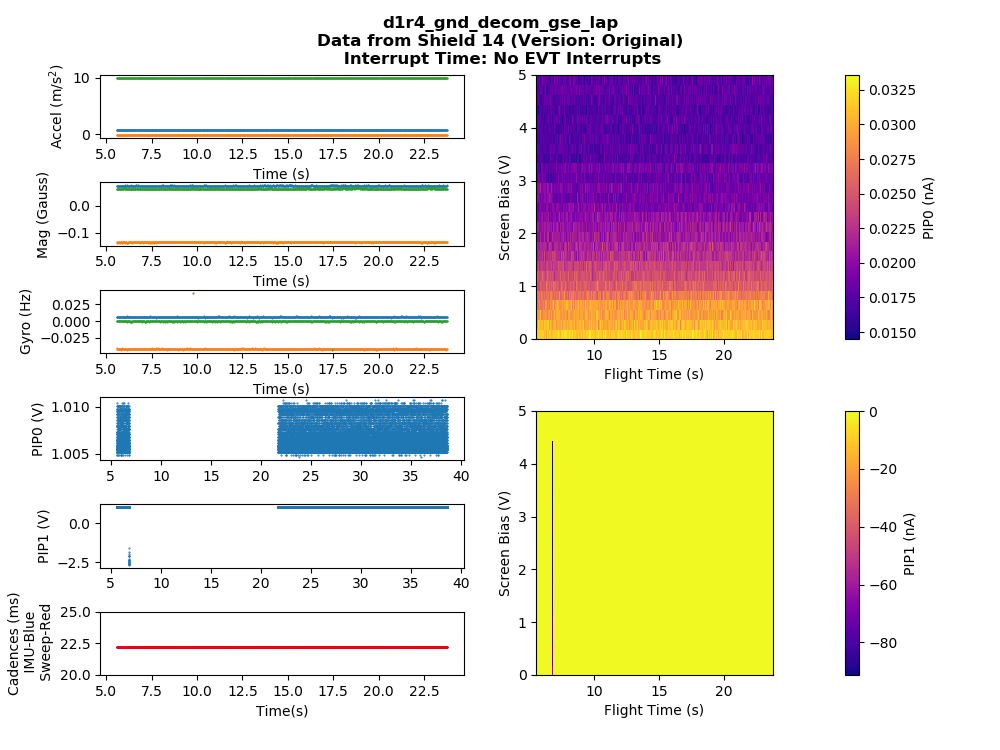

1/8 Done
2/8 Done
3/8 Done
4/8 Done
5/8 Done
6/8 Done
7/8 Done
8/8 Done


In [15]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1

fig = plt.figure(figsize=(10, 7.5))

# **plot IMU time vs IMU data**
axis = fig.add_subplot(gs_left[0,0])
plt.plot(imuPlot, axPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, ayPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, azPlot, line_style, markersize=markersize) 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
if lp_xlims is None: lp_xlims = axis.get_xlim()
plt.xlim(lp_xlims)
print ("1/8 Done")

fig.add_subplot(gs_left[1,0])
plt.plot(imuPlot, mxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, myPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, mzPlot, line_style, markersize=markersize) 
#plt.ylim([-0.02, 0.06])
plt.ylabel("Mag (Gauss)")
#plt.ylim([-0.3, 0.3])    
plt.xlim(lp_xlims)
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2/8 Done")

fig.add_subplot(gs_left[2,0])
plt.plot(imuPlot, gxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, gyPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, gzPlot, line_style, markersize=markersize) 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])   
plt.xlim(lp_xlims)
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3/8 Done")

# fig.add_subplot(gs_left[2,0], sharex=axis)
# plt.plot(imuPlot, tempPlot, line_style, markersize=markersize)
# #plt.ylim([-1, 1])
# plt.ylabel("Temp C$^o$")
# plt.xlabel("Time (s)")
# print ("3/7 Done")

# Plot sweep data (line)
# First PIP
fig.add_subplot(gs_left[3,0])
plt.plot(sweepTimeLPlot, pip0LPlot, line_style, markersize=markersize)
plt.ylabel("PIP0 (V)")
###plt.ylim([1.3, 2.1])
##plt.ylim([1.3, 2.4])
##plt.ylim([0.5, 1.5])
#plt.ylim([0, .0022])
#plt.xlim([imuTime[0]-20, imuTime[-1]+20])
plt.xlim(xlims)
plt.ylim(ylims)
print("4/8 Done")

# Second PIP
fig.add_subplot(gs_left[4,0])
plt.plot(sweepTimeLPlot, pip1LPlot, line_style, markersize=markersize)
###plt.ylim([1, 1.5])
##plt.ylim([0.5, 1.5])
#plt.ylim([0, .0022])
#plt.xlim([imuTime[0]-20, imuTime[-1]+20])
plt.xlim(xlims)
plt.ylim(ylims)
plt.ticklabel_format(style='plain')
plt.ylabel("PIP1 (V)")
print("5/8 Done")

fig.add_subplot(gs_left[5,0])
if xIndex: 
    plt.plot(np.diff(imuPlot)*1e3, line_style, color='blue', markersize=markersize)
    plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
    plt.xlim([0, np.max([len(np.diff(imuPlot)), len(np.diff(sweepPlot))])])
    plt.xlabel("Index")
else: 
    plt.plot(imuPlot[1:], np.diff(imuPlot)*1e3, line_style, color='blue', markersize=markersize)
    plt.plot(sweepPlot[1:], np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
    if use_xlp: plt.xlim(lp_xlims)
    else: plt.xlim([0, np.max([np.max(imuPlot), np.max(sweepPlot)])])
    plt.xlabel("Time(s)")
    
plt.ylim(cad_ylims)
#plt.ylim([20,25])
#plt.ylim([22,22.5])
#plt.ylim(None)
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
#plt.xlabel("Index")
print ("6/8 Done")

# **Plot sweep time vs sweep data (Color plots)**

# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'


ax1 = plt.subplot2grid((4,2),(0,1),rowspan = 2)
#plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', vmin = 0.5, vmax = 2.5)#3.75)
plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
#plt.ylim([0,2])
#plt.xlim([600,605])
plt.xlim(xlims)
#plt.xlim([sweepPlot[0],sweepPlot[-1]])
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("7/8 Done")

ax1 = plt.subplot2grid((4,2),(2,1),rowspan = 2)
#plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', vmin = .5, vmax = 2.5)
plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
#plt.ylim([0,2])
#plt.xlim([600,605])
plt.xlim(xlims)
#plt.xlim([sweepPlot[0],sweepPlot[-1]])
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("8/8 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)

if interruptValue and len(interruptArray) > 100:
    interruptNum = str(np.round(interruptArray[0], decimals=3)) + " seconds"
elif len(set(interruptArray)) > 1 and len(interruptArray) > 100:
#    interruptNum = "Multiple EVT Interrupts (first=%s, last=%ss)" % (np.min(interruptArray), np.max(interruptArray))
    interruptNum = "Multiple (%ss-%ss)" % tuple(np.round(val, decimals=3) for val in [np.min(interruptArray), np.max(interruptArray)])
elif len(interruptArray)<100 and not len(set(interruptArray))==0:
    interruptNum = "Fewer InterruptArray Recordings than Required for EVT Classification"
else:
    interruptNum = "No EVT Interrupts"
    
if GPS_time is None: 
    plt.suptitle(file_name+"\n"+"Data from Shield %s (Version: %s)\n Interrupt Time: %s" 
             %(shieldID, plottype, interruptNum), fontweight='bold')
else: 
    if not hasattr(GPS_time, '__iter__'): GPS_time=[GPS_time]
    #GPS_time = tuple(time for time in GPS_time)
    gps_str=", ".join(["%s-%ss" % val for val in zip(["ON", "OFF"]*len(GPS_time), GPS_time)])
    plt.suptitle(file_name+"\n"+"Data from Shield %s (Version: %s)\nInterrupt Time: %s; GPS ON/OFF Times: %s"
                 %(shieldID, plottype, interruptNum, gps_str), fontweight='bold')
plt.show()

In [36]:
#if not os.path.exists(path+'Figures/'): os.makedirs(path+'Figures/')
#fig.savefig(path+'figure%s.png' %('-'+plottype))
fig.savefig(path+'figure_%s-%s.png' %(plottype.lower(), file_name.partition(".")[0]))

In [37]:

import os
fig_path = "./Figures/Main_Vacuum/"
if not os.path.exists(fig_path): os.makedirs(fig_path)
fig.savefig(fig_path+'Plot_%s-%s%s.png' % (plottype, dataFile.split('data_file_230k-')[-1].split('.')[0], extra_note))

print GPS_time

None


In [38]:
## Table of PIP Voltage and Noise Analysis ##
print "%%%%%%% Mean PIP Recorded Voltage Levels %%%%%%%"
print "------------------------------------------------------------------------------------------------"
print "PIP 1 Mean Voltage = %s V; PIP 2 Mean Voltage = %s V" %(np.nanmean(pip0), np.nanmean(pip1))
print "PIP 1 Rpt Mean Voltage = %s V; PIP 2 Rpt Mean Voltage = %s V" %(np.nanmean(pip0Rpt), np.nanmean(pip1Rpt))
print "------------------------------------------------------------------------------------------------"

print "\n%%%%%%% Noise in PIP Measurements %%%%%%%"
from prettytable import PrettyTable
#print "\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'"
print "Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage"
noise1 = pip0-np.nanmean(pip0)
noise2 = pip1-np.nanmean(pip1)
noise1Rpt = pip0Rpt-np.nanmean(pip0Rpt)
noise2Rpt = pip1Rpt-np.nanmean(pip1Rpt)
#print "---------------------------------------------------------------------------"
#print '%%%%%%%%%% Approximate Noise Statistics %%%%%%%%%%%'
#print "Approximate Noise Statistics:"
t = PrettyTable(['Source', 'Mean{Noise}', 'Mean{|Noise|}', 'Min', 'Max', 'Time of Min & Max', '(Max-Min)/2'])
for noise_arr, name  in zip([noise1, noise1Rpt, [9, 12, 13, 9, 9, 18, 10], noise2, noise2Rpt], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
    if name is not 'split': 
        row_arr = [name]
        row_arr.append('~ %s V' %(np.format_float_scientific(np.nanmean(noise_arr), precision=1)))
        row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(np.abs(noise_arr)), np.nanmin(noise_arr), np.nanmax(noise_arr)]])
        if name[-3:] != 'Rpt': row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepTime[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
        else: row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepTimeRpt[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
        row_arr.append('~ %s mV' % (np.round((np.nanmax(noise_arr)-np.nanmin(noise_arr))/2.*1e3, decimals=1)))
    ## Create section split between pip1&pip2 data
    else: row_arr=['-'*ln for ln in noise_arr]
    t.add_row(row_arr); del row_arr
print t
del t 

print "\n%%%%%%% Envelope of PIP Noise %%%%%%%"
print "Noise Delta{Vmax} = Mean{PIP Noise > 0 & PIP Noise < Vmax} - Mean{PIP Noise < 0, PIP Noise>-Vmax}"
print "[Note: if Vmax is unspecified then upper/lower limit is infinity.]"
#footer=""
t = PrettyTable(); t.right_padding_width=0; t.left_padding_width=0
t.field_names = ['Source', '|', 'Mean{Noise<0}', 'Mean{0<Noise}', 'Noise Delta', '', 'Min{-1<Noise<0}', 'Max{0<Noise<1}', '(Max-Min)/2']
charArr=['-']*len(t.field_names); charArr[t.field_names.index(u'|')] = '|'
for noiseArr, name  in zip([noise1, noise1Rpt, [9, 1, 15, 15, 14, 0, 17, 17, 10], noise2, noise2Rpt], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
    if name is not 'split': 
        noise_arr = noiseArr[np.logical_not(np.isnan(noiseArr))]
        row_arr = [name, '|']
        pos_locs = np.where(0<noise_arr)
        neg_locs = np.where(noise_arr<0)
#        row_arr.append('~ %s mV' %(np.format_float_scientific(np.nanmean(noise_arr[pos_lo]), precision=1)))
        #row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs]), np.nanmean([np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs])]), np.nanmin(noise_arr), np.nanmax(noise_arr)]])
        row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(noise_arr[neg_locs]), np.nanmean(noise_arr[pos_locs]), np.subtract(np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs]))]])
        row_arr.append('')
        nmax = np.max(noise_arr[np.where(np.logical_and(0<noise_arr, noise_arr<1.))])
        nmin = np.min(noise_arr[np.where(np.logical_and(-1.<noise_arr, noise_arr<0))])
        row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [nmin, nmax, (nmax-nmin)/2.]])
        
#        if len(np.where(1.<= np.abs(noise_arr))[0].tolist()) != 0: footer= footer+"\n%s has noise value >= 1V at record %s" % (name, ", ".join(np.unique(np.where(1.<=np.abs(noiseArr))[0])))
 #       if len(np.where(0.==np.abs(noise_arr))[0].tolist()) != 0: footer = footer+" and noise value==0V at record %s" % (", ".joinnp.unique(np.where(0.==np.abs(noiseArr))[0]))
        #if not len(np.where(1.<= np.abs(noiseArr))[0]) == 0: print ", ".join(np.unique(np.where(1.<=np.abs(noiseArr))[0]))
        #else: print None
        #if name[-3:] != 'Rpt': row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTime[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
        #else: row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTimeRpt[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))    ## Create section split between pip1&pip2 data
    else: 
        row_arr=[char*ln for char, ln in zip(charArr, noiseArr)]
    t.add_row(row_arr); del row_arr
print t
#print footer

%%%%%%% Mean PIP Recorded Voltage Levels %%%%%%%
------------------------------------------------------------------------------------------------
PIP 1 Mean Voltage = 1.0104257124731701 V; PIP 2 Mean Voltage = 1.0119445134550684 V
PIP 1 Rpt Mean Voltage = 1.009969970603901 V; PIP 2 Rpt Mean Voltage = 1.010158710134778 V
------------------------------------------------------------------------------------------------

%%%%%%% Noise in PIP Measurements %%%%%%%
Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage
+-----------+--------------+---------------+---------------+-------------+---------------------------+-------------+
|   Source  | Mean{Noise}  | Mean{|Noise|} |      Min      |     Max     |     Time of Min & Max     | (Max-Min)/2 |
+-----------+--------------+---------------+---------------+-------------+---------------------------+-------------+
|   PIP 1   | ~ -7.3e-18 V |    ~ 0.3 mV   |   ~ -2.4 mV   |   ~ 1.5 mV  | ~ 25.584988s & 23.651584s |   ~ 2.0 mV  |

In [39]:
tmp = [9, 0, 15, 15, 13, 0, 17, 17, 10]
tmp[tmp.index(0)] = ''
noiseArr=noise1
noise_arr = noiseArr[np.logical_not(np.isnan(noiseArr))]
print 'Noise>=1', np.where(1.<= np.abs(noise_arr)), ';', np.where(1.<=np.abs(noiseArr))
print 'Noise=0', np.where(1.==np.abs(noise_arr)), ';', np.where(1.==np.abs(noiseArr))

#noise_arr = noise2
#print np.where(noise_arr==np.nanmin(noise_arr))
#print np.where(noise_arr==np.nanmax(noise_arr))
#print sweepSampleTime[np.where(noise_arr==np.nanmin(noise_arr))[0]]
#print sweepSampleTime[np.where(noise_arr==np.nanmax(noise_arr))[0]]
print noiseArr.shape, noise_arr.shape
print noiseArr.shape[0]*noiseArr.shape[1], '==>', noiseArr.shape[0]*noiseArr.shape[1]-noise_arr.shape[0], 'nan values'


Noise>=1 (array([], dtype=int64),) ; (array([], dtype=int64), array([], dtype=int64))
Noise=0 (array([], dtype=int64),) ; (array([], dtype=int64), array([], dtype=int64))
(3569, 28) (98392,)
99932 ==> 1540 nan values


/Users/ionosphere/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


In [40]:
## Table of PIP Voltage and Noise Analysis (Using Lineplot Data) ##
print "%%%%%%% Mean PIP Recorded Voltage Levels %%%%%%%"
print "------------------------------------------------------------------------------------------------"
print "PIP 1 Mean Voltage = %s V; PIP 2 Mean Voltage = %s V" %(np.nanmean(pip0L), np.nanmean(pip1L))
print "PIP 1 Rpt Mean Voltage = %s V; PIP 2 Rpt Mean Voltage = %s V" %(np.nanmean(pip0RptL), np.nanmean(pip1RptL))
print "------------------------------------------------------------------------------------------------"

print "\n%%%%%%% Noise in PIP Measurements %%%%%%%"
from prettytable import PrettyTable
#print "\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'"
print "Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage"
noise1 = pip0L-np.nanmean(pip0L)
noise2 = pip1L-np.nanmean(pip1L)
noise1Rpt = pip0RptL-np.nanmean(pip0RptL)
noise2Rpt = pip1RptL-np.nanmean(pip1RptL)
#print "---------------------------------------------------------------------------"
#print '%%%%%%%%%% Approximate Noise Statistics %%%%%%%%%%%'
#print "Approximate Noise Statistics:"
t = PrettyTable(['Source', 'Mean{Noise}', 'Mean{|Noise|}', 'Min', 'Max', 'Time of Min & Max'])
for noise_arr, name  in zip([noise1, noise1Rpt, [9, 12, 13, 9, 9, 18], noise2, noise2Rpt], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
    if name is not 'split': 
        row_arr = [name]
        row_arr.append('~ %s V' %(np.format_float_scientific(np.nanmean(noise_arr), precision=1)))
        row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(np.abs(noise_arr)), np.nanmin(noise_arr), np.nanmax(noise_arr)]])
        if name[-3:] != 'Rpt': row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTime[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
        else: row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTimeRpt[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
    ## Create section split between pip1&pip2 data
    else: row_arr=['-'*ln for ln in noise_arr]
    t.add_row(row_arr); del row_arr
print t

print "\n%%%%%%% Noise Envelope %%%%%%%"
from prettytable import PrettyTable
print "Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage"
#t = PrettyTable(['Source', 'Mean{Noise>0}', 'Mean{Noise<0}', 'Delta Mean', 'Min', 'Max', 'Time of Min & Max'])
#for noise_arr, name  in zip([noise1, noise1Rpt, [9, 12, 13, 10, 9, 9, 18], noise2, noise2Rpt], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
t = PrettyTable(['Source', 'Mean{Noise>0}', 'Mean{Noise<0}', 'Mean Noise Delta'])
for noise_arr, name  in zip([noise1, noise1Rpt, [9, 12, 13, 12], noise2, noise2Rpt], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
    if name is not 'split': 
        row_arr = [name]
        pos_locs = np.where(0<noise_arr)
        neg_locs = np.where(noise_arr<0)
#        row_arr.append('~ %s mV' %(np.format_float_scientific(np.nanmean(noise_arr[pos_lo]), precision=1)))
        #row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs]), np.nanmean([np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs])]), np.nanmin(noise_arr), np.nanmax(noise_arr)]])
        row_arr.extend(['~ %s mV' % (np.round(val*1e3, decimals=1)) for val in [np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs]), np.subtract(np.nanmean(noise_arr[pos_locs]), np.nanmean(noise_arr[neg_locs]))]])
        #if name[-3:] != 'Rpt': row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTime[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))
        #else: row_arr.append('~ %ss & %ss' % tuple([np.format_float_positional(np.unique(sweepSampleTimeRpt[np.where(noise_arr==val)[0]])[0], precision=6) for val in [np.nanmin(noise_arr), np.nanmax(noise_arr)]]))    ## Create section split between pip1&pip2 data
    else: row_arr=['-'*ln for ln in noise_arr]
    t.add_row(row_arr); del row_arr
print t

%%%%%%% Mean PIP Recorded Voltage Levels %%%%%%%
------------------------------------------------------------------------------------------------
PIP 1 Mean Voltage = 1.0104257124731701 V; PIP 2 Mean Voltage = 1.0119445134550684 V
PIP 1 Rpt Mean Voltage = 1.009969970603901 V; PIP 2 Rpt Mean Voltage = 1.010158710134778 V
------------------------------------------------------------------------------------------------

%%%%%%% Noise in PIP Measurements %%%%%%%
Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage
+-----------+--------------+---------------+---------------+-------------+---------------------------+
|   Source  | Mean{Noise}  | Mean{|Noise|} |      Min      |     Max     |     Time of Min & Max     |
+-----------+--------------+---------------+---------------+-------------+---------------------------+
|   PIP 1   | ~ -7.3e-18 V |    ~ 0.3 mV   |   ~ -2.4 mV   |   ~ 1.5 mV  | ~ 25.029984s & 23.133074s |
| PIP 1 Rpt | ~ 8.7e-17 V  |    ~ 1.0 mV   |  ~ -2343.6

In [70]:
## PIP Noise Analysis ##
noise1 = np.nanmean(pip0)-pip0
noise2 = np.nanmean(pip1)-pip1
print "%%%%%% Original Data %%%%%%%%"
print "-----------------------------"
print "PIP 1 Mean = %s; PIP 2 Mean = %s" %(np.nanmean(pip0), np.nanmean(pip1))
print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Avg(|Noise|) ~= %s mV" % tuple([np.round(val, decimals=1) for val in [np.nanmin(noise1)*1e3, np.nanmax(noise1)*1e3, np.nanmean(np.abs(noise1))*1e3]])+"; Avg(Noise) ~= %s V" %(np.format_float_scientific(np.nanmean(noise1), precision=1))
print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Avg(|Noise|) ~= %s mV" % tuple([np.round(val, decimals=1) for val in [np.nanmin(noise2)*1e3, np.nanmax(noise2)*1e3, np.nanmean(np.abs(noise2))*1e3]])+"; Avg(Noise) ~= %s V" %(np.format_float_scientific(np.nanmean(noise2), precision=1))

print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
print "\n%%%%%%% Repeat Data %%%%%%%%%"
print "-----------------------------"
noise1Rpt = np.nanmean(pip0Rpt)-pip0Rpt
noise2Rpt = np.nanmean(pip1Rpt)-pip1Rpt
print "PIP 1 Rpt Mean = %s; PIP 2 Rpt Mean = %s" %(np.nanmean(pip0Rpt), np.nanmean(pip1Rpt))
print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Avg(|Noise|) ~= %s mV" % tuple([np.round(val, decimals=1) for val in [np.nanmin(noise1Rpt)*1e3, np.nanmax(noise1Rpt)*1e3, np.nanmean(np.abs(noise1Rpt))*1e3]])+"; Avg(Noise) ~= %s V" %(np.format_float_scientific(np.nanmean(noise1Rpt), precision=1))
print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Avg(|Noise|) ~= %s mV" % tuple([np.round(val, decimals=1) for val in [np.nanmin(noise2Rpt)*1e3, np.nanmax(noise2Rpt)*1e3, np.nanmean(np.abs(noise2Rpt))*1e3]])+"; Avg(Noise) ~= %s V" %(np.format_float_scientific(np.nanmean(noise2Rpt), precision=1))
print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"

%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 1 Mean = 1.021725032186371; PIP 2 Mean = 1.0305288589776398
PIP 1 Noise: Min ~= -1.8 mV; Max ~= 2.4 mV; Avg(|Noise|) ~= 0.5 mV; Avg(Noise) ~= -7.e-17 V
PIP 2 Noise: Min ~= -0.4 mV; Max ~= 0.9 mV; Avg(|Noise|) ~= 0.1 mV; Avg(Noise) ~= 2.1e-17 V
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%%%%%% Repeat Data %%%%%%%%%
-----------------------------
PIP 1 Rpt Mean = 1.0216978769650433; PIP 2 Rpt Mean = 1.0305123696590195
PIP 1 Noise: Min ~= -1.9 mV; Max ~= 2.4 mV; Avg(|Noise|) ~= 0.5 mV; Avg(Noise) ~= -9.e-17 V
PIP 2 Noise: Min ~= -0.4 mV; Max ~= 1.2 mV; Avg(|Noise|) ~= 0.1 mV; Avg(Noise) ~= -2.5e-17 V
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [15]:
(np.format_float_positional(np.nanmin(noise1), precision=2))


'-3.99'

In [12]:
### From Shield 2 GPS Frequency Investigations ###
print "File path %s \n" % dataFile
print 'IMU Time Range: %ss-%ss' % (imuList[0], imuList[-1])
print 'Sweep  Time Range: %ss-%ss' % (sweepList[0], sweepList[-1])
GPS_arr = np.arange(np.round(GPS_rng[0], decimals=2), np.round(GPS_rng[1], decimals=2), 30)
freq_arr = []
freqs=[5, 50, 500, 5000]
for inx in np.arange(0, len(GPS_arr)):
    if len(freqs)<=inx: inx =inx-len(freqs)
    freq_arr.append(freqs[inx])
print '\nTime GPS Changed | Frequency GPS Changed To'
print '-'*(48)
for time, freq in zip(GPS_arr, freq_arr): print '\t%ss\t | %s Hz' % (np.round(time, decimals=2), freq)
#print GPS_arr
#print freq_arr

File path ./Delamere_Vacuum_Tests/Main_Bench/data_file_230k-Shield21_PostAssembly_newGPSsim-01_01_21.txt 

IMU Time Range: 9.460064s-464.90786s
Sweep  Time Range: 9.457576s-464.905376s


NameError: name 'GPS_rng' is not defined

In [110]:
### From Shield 2 GPS Frequency Investigations ###
int(len(GPS_arr) / len(freqs))
len('Time GPS Change to Frequency \t|\t Frequency')

42

In [50]:
"""%%%% Noisy Event Interrupt Cleaning %%%%"""
max_dt = 10
if not len(interrupt)==0:
    #prev=np.unique(np.array(interruptTime)/10.**6)[0]
    gprev = np.unique(np.array(interruptTime)/10.**6)[0]
    newEventTimes=[]
    newEventNum=[]
    newEvent=[]
    tmp = []
    cnt = 0
    for event in np.unique(np.array(interruptTime)/10.**6):
        if np.round(event, decimals=0)-np.round(gprev, decimals=0) < max_dt: 
            tmp.append(event)
            cnt = cnt+len(np.where(np.array(interruptTime)/10.**6 == event)[0])
        else: 
            #Reset temporary variables
            newEventTimes.append(tmp); tmp = []
            newEventNum.append(cnt); cnt = 0
            newEvent.append(np.round(gprev, decimals = 0)); gprev = event
            #Save this event information
            tmp.append(event)
            cnt = cnt+len(np.where(np.array(interruptTime)/10.**6 == event)[0])
    #Save Final Event Information
    newEventTimes.append(tmp)
    newEventNum.append(cnt)
    newEvent.append(np.round(gprev, decimals = 0))
    del tmp, cnt, gprev
    
    print "File name %s" % dataFile
    print"Num interrupt messages for payload %s: %s" %(payloadID[0], len(interrupt))
    print "Num unique interrupt times: ", len(np.unique(np.array(interruptTime)/10.**6))
    print "\nTimes are grouped together if they are within %ss of eachother" % (max_dt)
    print "Num unique grouped interrupt times: ", len(np.unique(np.array(interruptTime)/10.**6))
    print '***************************************'
    prev = newEvent[0]
    for event, count, sublst in zip(np.array(newEvent), np.array(newEventNum), newEventTimes):         
        if int(np.floor(event-prev)) >= 30: print "-----------------------------------------"
        print "Number of recordings for ~%ss:" % (event), count, "\tNumber of unique times in %ss group:" %(event), len(sublst)
        prev=event
else: 
    print "No Event Interrupts Recieved"

File name ./Delamere_Vacuum_Tests/Bob_Vacuum/Shield14/data_file_230k-Shield14_Plasma_RollCWsweep15_PitchUp10-12_02_20.txt
Num interrupt messages for payload 14: 1376
Num unique interrupt times:  37

Times are grouped together if they are within 10s of eachother
Num unique grouped interrupt times:  37
***************************************
Number of recordings for ~27.0s: 95 	Number of unique times in 27.0s group: 2
Number of recordings for ~37.0s: 404 	Number of unique times in 37.0s group: 4
Number of recordings for ~47.0s: 404 	Number of unique times in 47.0s group: 9
Number of recordings for ~57.0s: 451 	Number of unique times in 57.0s group: 8
-----------------------------------------
Number of recordings for ~172.0s: 1 	Number of unique times in 172.0s group: 1
Number of recordings for ~182.0s: 1 	Number of unique times in 182.0s group: 1
Number of recordings for ~192.0s: 1 	Number of unique times in 192.0s group: 1
-----------------------------------------
Number of recordings f